In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
%pwd

/home/markus/Documents/regression-prediction


'/home/markus/Documents/regression-prediction'

In [3]:
from experiments.modeleval_utils import *
from sklearn.model_selection import cross_validate

/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
def evaluate_pipeline(output_dir, model, target, data, feature_type, scoring, X_train, y_train, X_test, y_test):
    evaluation = {'model': model}

    pipeline, best_params, best_result = get_pipeline(output_dir, data, feature_type, target, scoring, model)

    y_test_proportion = len(y_test) / (len(y_train) + len(y_test))
    tscv = TimeSeriesSplit(n_splits=5, test_size=round(len(y_train) * y_test_proportion))
    res = cross_validate(pipeline, X_train, y_train, scoring=['average_precision', 'roc_auc'], cv=tscv, n_jobs=5)
    evaluation['validation'] = res
    
    pipeline.fit(X_train, y_train)
    evaluation['fitted_pipeline'] = pipeline
    evaluation['best_params'] = best_params
    evaluation['best_result'] = best_result

    threshold_train, f1_train = get_best_f1_threshold(pipeline, X_train, y_train)
    threshold_test, f1_test = get_best_f1_threshold(pipeline, X_test, y_test)
    print(f'{threshold_train=} {f1_train=}, {threshold_test=}, {f1_test=}')

    for (split, X_, y_, threshold) in [
        ('train', X_train, y_train, threshold_train),
        ('test', X_test, y_test, threshold_train),
        ('test_pareto', X_test, y_test, threshold_test)
        ]:

        y_score = get_y_score(pipeline, X_)
        y_pred = y_score >= threshold

        evaluation[split] = {
            'average_precision': metrics.average_precision_score(y_, y_score),
            'roc_auc': metrics.roc_auc_score(y_, y_score),

            'threshold': threshold,
            
            'regression': {
                'recall': metrics.recall_score(y_, y_pred, pos_label=1),
                'precision': metrics.precision_score(y_, y_pred, pos_label=1, zero_division=0),
                'f1': metrics.f1_score(y_, y_pred, pos_label=1)
            },
            'non-regression': {
                'recall': metrics.recall_score(y_, y_pred, pos_label=0),
                'precision': metrics.precision_score(y_, y_pred, pos_label=0, zero_division=0),
                'f1': metrics.f1_score(y_, y_pred, pos_label=0)
            },
            'avg_weighted': {
                'recall': metrics.recall_score(y_, y_pred, average='weighted'),
                'precision': metrics.precision_score(y_, y_pred, average='weighted', zero_division=0),
                'f1': metrics.f1_score(y_, y_pred, average='weighted')
            },
            'avg_macro': {
                'recall': metrics.recall_score(y_, y_pred, average='macro'),
                'precision': metrics.precision_score(y_, y_pred, average='macro', zero_division=0),
                'f1': metrics.f1_score(y_, y_pred, average='macro')
            }
        }

    
    return evaluation

def evaluate_pipelines(output_dir, target, data, feature_type, scoring, X_train, y_train, X_test, y_test):
    evaluations = []
    for model in models:
        print(model)
        try:
            evaluation = evaluate_pipeline(output_dir, model, target, data, feature_type, scoring, X_train, y_train, X_test, y_test)
            evaluations.append(evaluation)
        except Exception as e:
            print(e)

    return evaluations


In [5]:
def get_overfit_stat_df(evaluation):
    columns = [
        np.array(['train', 'train', 'validation', 'validation', 'test', 'test']),
        np.array(['Avg. Precision', 'AUC', 'Avg. Precision', 'AUC', 'Avg. Precision', 'AUC']),
    ]

    df = pd.DataFrame([[
        evaluation['train']['average_precision'],
        evaluation['train']['roc_auc'],
        evaluation['validation']['test_average_precision'].mean(),
        evaluation['validation']['test_roc_auc'].mean(),
        evaluation['test']['average_precision'],
        evaluation['test']['roc_auc']
        ]],
        index=[model_names[evaluation['model']]],
        columns=columns)
    return df

In [26]:
def get_classification_report_df(evaluation):
    dfs = []
    for split in ['train', 'test', 'test_pareto']:
        df = pd.DataFrame(
            [
                evaluation[split]['regression'],
                evaluation[split]['non-regression']
                # evaluation[split]['avg_macro'],
                # evaluation[split]['avg_weighted']
            ],
            index=[
                [model_names[evaluation['model']]]*2,
                ['regression', 'non-regression']#, 'weighted average', 'micro average']
                ]
        )
        df.columns = [
            np.array([split]*3),
            np.array(['recall', 'precision', 'F1'])
        ]
        dfs.append(df)

    classification_reports = pd.concat(dfs, axis=1)

    return classification_reports

In [7]:
output_dir = 'experiments/results_FS'
drop_columns = True

In [8]:
evaluations_by_config = {}
for (data, target) in [('fixed_defect_szz', 'performance'), ('bugbug_buglevel', 'performance'), ('bugbug_buglevel', 'regression')]:
    for feature_type in ['traditional', 'bow']:
        print('\n\n', '--> ', data, target, feature_type, '\n\n')
        scoring = 'average_precision'

        X, y, features = data_map[feature_type][data](target, drop_columns)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

        evaluations = evaluate_pipelines(output_dir, target, data, feature_type, scoring, X_train, y_train, X_test, y_test)
        evaluations_by_config[f'{data}_{target}_{feature_type}'] = evaluations



 -->  fixed_defect_szz performance traditional 


performance: 589 positive 0.59% - negative 99105 99.41%
X.shape=(99694, 55)

dummy
threshold_train=0.006319379430252775 f1_train=0.012559391301458618, threshold_test=0.006319379430252775, f1_test=0.004403522818254604
lr
threshold_train=0.8136786344906396 f1_train=0.041892940263770356, threshold_test=0.8000775810628395, f1_test=0.039408866995073885
svm
threshold_train=0.666004133321195 f1_train=0.07427785419532325, threshold_test=0.74360260621593, f1_test=0.021052631578947368
rf
threshold_train=0.8913696424621756 f1_train=0.9773123909249564, threshold_test=0.6242405566576075, f1_test=0.03478260869565217
xgb


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWar

threshold_train=0.87849313 f1_train=0.2476340694006309, threshold_test=0.4901714, f1_test=0.01066260472201066
mlp


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

threshold_train=0.8883079902139176 f1_train=0.11463250168577208, threshold_test=0.498033880481243, f1_test=0.009074410163339382
tpot


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/pyth

threshold_train=0.081046134 f1_train=0.3752244165170556, threshold_test=0.14225098, f1_test=0.08


 -->  fixed_defect_szz performance bow 


performance: 589 positive 0.59% - negative 99105 99.41%
X.shape=(99694, 50000)

dummy
threshold_train=0.006319379430252775 f1_train=0.012559391301458618, threshold_test=0.006319379430252775, f1_test=0.004403522818254604
lr


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


threshold_train=0.07815754549144409 f1_train=0.40163265306122453, threshold_test=0.219178558185332, f1_test=0.07692307692307693
svm


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

threshold_train=1.2054027952859991 f1_train=0.21732114039806347, threshold_test=1.5349569906873244, f1_test=0.07547169811320754
rf
threshold_train=0.024777446032660674 f1_train=0.7046379170056958, threshold_test=0.021272074888064523, f1_test=0.02666666666666667
xgb


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWar

threshold_train=0.10551256 f1_train=0.4064293915040183, threshold_test=0.12772685, f1_test=0.04081632653061224
mlp
[Errno 2] No such file or directory: 'experiments/results_FS/fixed_defect_szz_bow_performance_average_precision_mlp.csv'
tpot
[Errno 2] No such file or directory: 'experiments/results_FS/fixed_defect_szz_bow_performance_average_precision_tpot_exported_pipeline.py'


 -->  bugbug_buglevel performance traditional 


performance: 1880 positive 2.77% - negative 66041 97.23%
X.shape=(67921, 56)

dummy
threshold_train=0.026812589975134145 f1_train=0.05222489524750267, threshold_test=0.026812589975134145, f1_test=0.0685243104918965
lr


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


threshold_train=0.7347832588716675 f1_train=0.13342932565394772, threshold_test=0.732772424800068, f1_test=0.17737003058103976
svm


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

threshold_train=0.4573122151312887 f1_train=0.19510236852669613, threshold_test=0.4512760672039633, f1_test=0.17176470588235296
rf
threshold_train=0.6844373397068748 f1_train=0.2208160593497709, threshold_test=0.5626787143508193, f1_test=0.15261044176706828
xgb
threshold_train=0.14308473 f1_train=0.542314335060449, threshold_test=0.078882076, f1_test=0.1414790996784566
mlp


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

threshold_train=0.8390152713539074 f1_train=0.2724509533020171, threshold_test=0.7105767377272653, f1_test=0.1553784860557769
tpot


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/pyth

threshold_train=0.2312765567765566 f1_train=0.9447708578143361, threshold_test=0.0975, f1_test=0.1619718309859155


 -->  bugbug_buglevel performance bow 


performance: 1880 positive 2.77% - negative 66041 97.23%
X.shape=(67921, 50000)

dummy
threshold_train=0.026812589975134145 f1_train=0.05222489524750267, threshold_test=0.026812589975134145, f1_test=0.0685243104918965
lr
threshold_train=0.11372902631795351 f1_train=0.4795918367346939, threshold_test=0.1097045420086026, f1_test=0.17808219178082194
svm
threshold_train=0.42612612214845313 f1_train=0.29361835900660166, threshold_test=0.3497753218115287, f1_test=0.17142857142857143
rf
threshold_train=0.7759179894179894 f1_train=0.7129833385727758, threshold_test=0.5755555555555554, f1_test=0.199252801992528
xgb
threshold_train=0.13846844 f1_train=0.6150583244962885, threshold_test=0.053653013, f1_test=0.16208393632416787
mlp
[Errno 2] No such file or directory: 'experiments/results_FS/bugbug_buglevel_bow_performance_average_precision_ml

/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


threshold_train=0.48684747469660383 f1_train=0.42012775096928956, threshold_test=0.5428553908018999, f1_test=0.39454939609786316
svm


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

threshold_train=0.1006652726993238 f1_train=0.44151404151404156, threshold_test=-0.05574227782312846, f1_test=0.4035621198957428
rf
threshold_train=0.28509794974675506 f1_train=0.8043578462183113, threshold_test=0.2560205389394595, f1_test=0.43796455117209837
xgb
threshold_train=0.25422105 f1_train=0.5069971454431526, threshold_test=0.18882969, f1_test=0.4281287246722288
mlp
threshold_train=0.2125585807393482 f1_train=0.4433658885183421, threshold_test=0.227005806422799, f1_test=0.4227687206410611
tpot


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [4] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [4] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packa

threshold_train=0.24967593 f1_train=0.5306709593451381, threshold_test=0.22831187, f1_test=0.4287660038136747


 -->  bugbug_buglevel regression bow 


regression: 14287 positive 21.03% - negative 53634 78.97%
X.shape=(67921, 50000)

dummy
threshold_train=0.2105254547834053 f1_train=0.34782491182074954, threshold_test=0.2105254547834053, f1_test=0.34539033004506153
lr
threshold_train=0.25255901008179193 f1_train=0.5024342745861733, threshold_test=0.19903315134959357, f1_test=0.3865583132000878
svm


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

threshold_train=0.11822900228128105 f1_train=0.429771265189421, threshold_test=0.09025835323231732, f1_test=0.3850401606425703
rf
threshold_train=0.43416137566137564 f1_train=0.9204340721498303, threshold_test=0.18844444444444444, f1_test=0.4230875448771058
xgb


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWar

threshold_train=0.2735196 f1_train=0.48878941688981253, threshold_test=0.25434327, f1_test=0.4157754010695187
mlp
[Errno 2] No such file or directory: 'experiments/results_FS/bugbug_buglevel_bow_regression_average_precision_mlp.csv'
tpot
[Errno 2] No such file or directory: 'experiments/results_FS/bugbug_buglevel_bow_regression_average_precision_tpot_exported_pipeline.py'


In [9]:
import pickle
with open(os.path.join(output_dir, 'evaluations.pickle'), 'wb') as f:
    pickle.dump(evaluations_by_config, f)

In [ ]:
import pickle
with  open(os.path.join(output_dir, 'evaluations.pickle'), 'rb') as f:
    evaluations_by_config = pickle.load(f)

In [10]:
list(evaluations_by_config.keys())

['fixed_defect_szz_performance_traditional',
 'fixed_defect_szz_performance_bow',
 'bugbug_buglevel_performance_traditional',
 'bugbug_buglevel_performance_bow',
 'bugbug_buglevel_regression_traditional',
 'bugbug_buglevel_regression_bow']

In [56]:
config = 'bugbug_buglevel_regression_traditional'
evaluations = evaluations_by_config[config]

In [57]:
ws = config.split('_')
feature_type = ws.pop()
target = ws.pop()
data = '_'.join(ws)
data, target, feature_type

('bugbug_buglevel', 'regression', 'traditional')

In [58]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [59]:
overfit_stats = pd.concat(
    [get_overfit_stat_df(evaluation) for evaluation in evaluations],
     axis=0)
overfit_stats

train            validation         \
                       Avg. Precision    AUC Avg. Precision    AUC   
Dummy Classifier               0.2105 0.5000         0.2167 0.5000   
Logistic Regression            0.3585 0.6697         0.3551 0.6619   
Support Vector Machine         0.4034 0.6996         0.3820 0.6806   
Random Forest                  0.8823 0.9367         0.4187 0.6979   
XGBoost                        0.5276 0.7669         0.4144 0.6996   
Multi-Layer Perceptron         0.4129 0.7038         0.3923 0.6887   
TPOT                           0.5655 0.7891         0.4244 0.7043   

                                 test         
                       Avg. Precision    AUC  
Dummy Classifier               0.2087 0.5000  
Logistic Regression            0.3565 0.6572  
Support Vector Machine         0.3508 0.6581  
Random Forest                  0.4173 0.7004  
XGBoost                        0.4143 0.6985  
Multi-Layer Perceptron         0.3764 0.6773  
TPOT                           0.4101 0.6943

In [60]:
for c in overfit_stats.columns: #[('test', 'Avg. Precision'), ('test', 'AUC')]:
    amax = overfit_stats.loc[:, c].argmax()
    overfit_stats.loc[overfit_stats.index[amax], c] = f'\\textbf{{{overfit_stats.iloc[amax][c]:.4f}}}'

In [61]:
print(overfit_stats.to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
{} & \multicolumn{2}{l}{train} & \multicolumn{2}{l}{validation} & \multicolumn{2}{l}{test} \\
{} &   Avg. Precision &              AUC &   Avg. Precision &              AUC &   Avg. Precision &              AUC \\
\midrule
Dummy Classifier       &           0.2105 &           0.5000 &           0.2167 &           0.5000 &           0.2087 &           0.5000 \\
Logistic Regression    &           0.3585 &           0.6697 &           0.3551 &           0.6619 &           0.3565 &           0.6572 \\
Support Vector Machine &           0.4034 &           0.6996 &           0.3820 &           0.6806 &           0.3508 &           0.6581 \\
Random Forest          &  \textbf{0.8823} &  \textbf{0.9367} &           0.4187 &           0.6979 &  \textbf{0.4173} &  \textbf{0.7004} \\
XGBoost                &           0.5276 &           0.7669 &           0.4144 &           0.6996 &           0.4143 &           0.6985 \\
Multi-Layer Perceptron &           0.4129 &

/tmp/ipykernel_23098/1422480635.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(overfit_stats.to_latex(escape=False))


In [62]:
classification_reports = pd.concat(
    [get_classification_report_df(evaluation) for evaluation in evaluations],
     axis=0)
classification_reports

train                    test  \
                                      recall precision     F1 recall   
Dummy Classifier       regression     1.0000    0.2105 0.3478 1.0000   
                       non-regression 0.0000    0.0000 0.0000 0.0000   
Logistic Regression    regression     0.5852    0.3277 0.4201 0.5515   
                       non-regression 0.6798    0.8601 0.7594 0.6607   
Support Vector Machine regression     0.5620    0.3636 0.4415 0.5071   
                       non-regression 0.7377    0.8633 0.7956 0.7213   
Random Forest          regression     0.7458    0.8729 0.8044 0.4746   
                       non-regression 0.9710    0.9348 0.9525 0.8076   
XGBoost                regression     0.5659    0.4592 0.5070 0.4986   
                       non-regression 0.8223    0.8766 0.8486 0.7713   
Multi-Layer Perceptron regression     0.5785    0.3594 0.4434 0.5635   
                       non-regression 0.7250    0.8658 0.7892 0.7034   
TPOT                   regression     0.6020    0.4745 0.5307 0.5099   
                       non-regression 0.8222    0.8857 0.8527 0.7620   

                                                       test_pareto            \
                                      precision     F1      recall precision   
Dummy Classifier       regression        0.2087 0.3454      1.0000    0.2087   
                       non-regression    0.0000 0.0000      0.0000    0.0000   
Logistic Regression    regression        0.3001 0.3887      0.4492    0.3517   
                       non-regression    0.8481 0.7427      0.7816    0.8432   
Support Vector Machine regression        0.3243 0.3956      0.6551    0.2916   
                       non-regression    0.8472 0.7792      0.5801    0.8644   
Random Forest          regression        0.3943 0.4307      0.5402    0.3683   
                       non-regression    0.8535 0.8299      0.7555    0.8617   
XGBoost                regression        0.3652 0.4216      0.6333    0.3234   
                       non-regression    0.8536 0.8104      0.6504    0.8705   
Multi-Layer Perceptron regression        0.3339 0.4193      0.5395    0.3476   
                       non-regression    0.8593 0.7736      0.7328    0.8578   
TPOT                   regression        0.3611 0.4228      0.5550    0.3493   
                       non-regression    0.8549 0.8058      0.7273    0.8610   

                                              
                                          F1  
Dummy Classifier       regression     0.3454  
                       non-regression 0.0000  
Logistic Regression    regression     0.3945  
                       non-regression 0.8112  
Support Vector Machine regression     0.4036  
                       non-regression 0.6943  
Random Forest          regression     0.4380  
                       non-regression 0.8051  
XGBoost                regression     0.4281  
                       non-regression 0.7445  
Multi-Layer Perceptron regression     0.4228  
                       non-regression 0.7904  
TPOT                   regression     0.4288  
                       non-regression 0.7885

In [63]:
for c in [('train', 'F1'), ('test', 'F1'), ('test_pareto', 'F1')]:
    reg = classification_reports.loc[pd.IndexSlice[:,'regression', :]]
    amax = reg[c].argmax()
    v = classification_reports.loc[(reg.index[amax], 'regression'), c]
    classification_reports.loc[(reg.index[amax], 'regression'), c] = f'\\textbf{{{v:.4f}}}'

In [64]:
s = classification_reports.to_latex(escape=False)
s = s.replace('Dummy Classifier', '\\multirow{2}{2.7cm}{Dummy\\\\Classifier}')
s = s.replace('\nLogistic Regression', '\\hline\\hline\n\\multirow{2}{2.7cm}{Logistic\\\\Regression}')
s = s.replace('\nSupport Vector Machine', '\\hline\\hline\n\\multirow{2}{2.7cm}{Support Vector\\\\Machine}')
s = s.replace('\nMulti-Layer Perceptron', '\\hline\\hline\n\\multirow{2}{2.7cm}{Multi-Layer\\\\Perceptron}')
s = s.replace('\nRandom Forest', '\\hline\\hline\nRandom Forest')
s = s.replace('\nXGBoost ', '\\hline\\hline\nXGBoost')
s = s.replace('\nTPOT ', '\\hline\\hline\nTPOT')
print(s)

\begin{tabular}{llrrlrrlrrl}
\toprule
     &                & \multicolumn{3}{l}{train} & \multicolumn{3}{l}{test} & \multicolumn{3}{l}{test_pareto} \\
     &                & recall & precision &               F1 & recall & precision &               F1 &      recall & precision &               F1 \\
\midrule
\multirow{2}{2.7cm}{Dummy\\Classifier} & regression & 1.0000 &    0.2105 &           0.3478 & 1.0000 &    0.2087 &           0.3454 &      1.0000 &    0.2087 &           0.3454 \\
     & non-regression & 0.0000 &    0.0000 &           0.0000 & 0.0000 &    0.0000 &           0.0000 &      0.0000 &    0.0000 &           0.0000 \\\hline\hline
\multirow{2}{2.7cm}{Logistic\\Regression} & regression & 0.5852 &    0.3277 &           0.4201 & 0.5515 &    0.3001 &           0.3887 &      0.4492 &    0.3517 &           0.3945 \\
     & non-regression & 0.6798 &    0.8601 &           0.7594 & 0.6607 &    0.8481 &           0.7427 &      0.7816 &    0.8432 &           0.8112 \\\hline\hline
\m

/tmp/ipykernel_23098/4178184239.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  s = classification_reports.to_latex(escape=False)


In [65]:
X, y, features = data_map[feature_type][data](target, drop_columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

regression: 14287 positive 21.03% - negative 53634 78.97%
X.shape=(67921, 56)



In [66]:
fitted_pipelines = [(model_names[evaluation['model']], evaluation['fitted_pipeline']) for evaluation in evaluations[1:]] # exclude dummy

/home/markus/Documents/regression-prediction/experiments/modeleval_utils.py:159: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * R * P / (R + P)


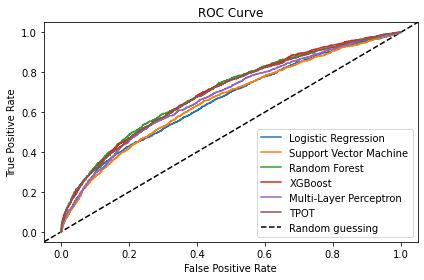

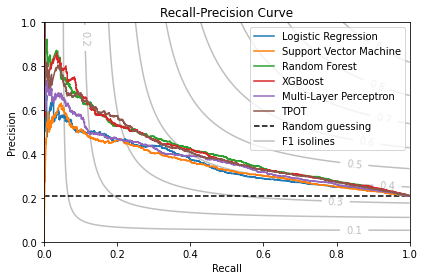

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
 <Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Recall-Precision Curve'}, xlabel='Recall', ylabel='Precision'>)

In [67]:
plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
    fitted_pipelines, X_train, X_test, y_train, y_test, save=True, figsize=(6,4), ylim=[0, 0.3 if data == 'fixed_defect_szz' else 1.0], output_dir=output_dir)

### Hyper Parameters

In [71]:
scoring = 'average_precision'
best_params_per_model = {}

for model in models:
    best_params_model = []
    for (data, target) in [('fixed_defect_szz', 'performance'), ('bugbug_buglevel', 'performance'), ('bugbug_buglevel', 'regression')]:
        for feature_type in ['traditional', 'bow']:
                try:
                    results = get_results(output_dir, data, feature_type, target, scoring, model)
                    params = get_params(results)
                    best_params = get_best_params(model, params)
                    del best_params['model']
                    best_params['sampler'] = str(best_params['sampler'])

                    index = {  
                        'Model': model_names[model],
                        'Data': data, 
                        'Feature Type': feature_type,
                        'Target': target
                        }
                    best_params_model.append({**index, **best_params})
                except FileNotFoundError:
                    pass
    if len(best_params_model) == 0:
        continue

    df = pd.DataFrame(best_params_model)
    df = df.replace({
                    'None': 'No sampling',
                    'RandomOverSampler(random_state=0)': 'Random Over-Sampling',
                    'RandomUnderSampler(random_state=0)': 'Random Under-Sampling',
                    'SMOTE(random_state=0)': 'SMOTE'
                    })

    df = df.replace({
        'fixed_defect_szz': 'SZZ',
        'bugbug_buglevel': 'bugbug'
    })
    df = df.replace({
        'performance': 'perf. regressions',
        'regression': 'all regressions',
        'bow': 'bag-of-words'
    })
    df.set_index(pd.MultiIndex.from_frame(df[['Data','Target', 'Feature Type',]]), inplace=True)
    df = df.drop(['Model','Data','Feature Type','Target'], axis=1)
    def rename_f(c):
        if 'model' in c:
            c = c[7:]
        if 'kernel' in c:
            c = c[8:]
        return c.capitalize()

    df = df.rename(rename_f, axis=1)
    best_params_per_model[model] = df
                

In [76]:
print(best_params_per_model['mlp'].to_latex())

\begin{tabular}{llllrrrl}
\toprule
       &                 &             & Activation &  Alpha &  Hidden\_layer\_sizes &  Learning\_rate\_init &               Sampler \\
Data & Target & Feature Type &            &        &                     &                     &                       \\
\midrule
SZZ & perf. regressions & traditional &       tanh & 0.0003 &                  50 &              0.0001 &                 SMOTE \\
bugbug & perf. regressions & traditional &       relu & 0.0001 &                 200 &              0.0001 &  Random Over-Sampling \\
       & all regressions & traditional &       relu & 0.0001 &                  10 &              0.0015 &           No sampling \\
\bottomrule
\end{tabular}



/tmp/ipykernel_23098/2920990339.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(best_params_per_model['mlp'].to_latex())


In [ ]:
scoring = 'average_precision'
feature_type = 'traditional'
target = 'performance'
data = 'fixed_defect_szz'

In [ ]:
X, y, features = get_ml_data_traditional('fixed_defect_szz', target, kind='commitlevel', drop_columns=lambda columns: [c for c in columns if 'delta_' in c or 'min_' in c or 'max_' in c or 'sum_' in c])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [ ]:
features.columns

In [ ]:
evaluation = evaluate_pipeline('lr', target, data, feature_type, scoring, X_train, y_train, X_test, y_test)

In [ ]:
get_classification_report_df(evaluation)

In [ ]:
pipeline = evaluation['fitted_pipeline']

In [ ]:
plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
    [('lr', pipeline)], X_train, X_test, y_train, y_test, save=True, figsize=(6,4), ylim=[0, 0.3 if data == 'fixed_defect_szz' else 1.0])

In [ ]:
import shap
from feature_name_map import feature_name_map
f = features

kind = 'traditional'
clf = pipeline['model']
if 'traditional' in kind:
    X_ = pipeline['scaler'].transform(X_test)
    f = f.drop('target', axis=1)
    feature_names = [feature_name_map[c] for c in f.columns]
else:
    X_ = X_test.toarray()
    feature_names = f

explainer = shap.Explainer(clf, X_, feature_names=feature_names)
print(explainer)
shap_values = explainer.shap_values(X_)

shap.summary_plot(shap_values, X_, max_display=15, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()